# Introduction to Multispectral Remote Sensing Data: Cold Springs Fire

For this assignment, you will visualize changes in vegetation health caused by the **2016 Cold Springs Fire in Colorado**. There is an earthpy data subset that contains these data, but for this assignment *you must download the data using APIs*.

## Get set up
### Package imports
Use the cell below to import the packages you need in the rest of the notebook (and **ONLY** the packages you need in the rest of the notebook).

In [11]:
# Import required for tests
import numpy as np
import glob
import pathlib
import os
import re
import requests

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr

### Working directory

Please put all your files into the `~/earth-analytics/data/cold-springs` directory to facilitate the reproducibility of your notebook. Use the cell below for any code needed to **cleanly** place all your files into that directory.

In [12]:
# Set working directory
os.chdir(os.path.join(
    pathlib.Path.home(), 'earth-analytics', 'data', 'cold-springs'))

In [13]:
%%bash
find ~/earth-analytics/data/cold-springs/naip-manual

/c/Users/nasim/earth-analytics/data/cold-springs/naip-manual
/c/Users/nasim/earth-analytics/data/cold-springs/naip-manual/m_3910505_nw_13_1_20150919
/c/Users/nasim/earth-analytics/data/cold-springs/naip-manual/m_3910505_nw_13_1_20150919/m_3910505_nw_13_1_20150919.tif
/c/Users/nasim/earth-analytics/data/cold-springs/naip-manual/m_3910505_nw_13_1_20150919/m_3910505_nw_13_1_20150919.txt
/c/Users/nasim/earth-analytics/data/cold-springs/naip-manual/m_3910505_nw_13_1_20150919.ZIP
/c/Users/nasim/earth-analytics/data/cold-springs/naip-manual/m_3910505_nw_13_1_20170902
/c/Users/nasim/earth-analytics/data/cold-springs/naip-manual/m_3910505_nw_13_1_20170902/m_3910505_nw_13_1_20170902.tif
/c/Users/nasim/earth-analytics/data/cold-springs/naip-manual/m_3910505_nw_13_1_20170902/m_3910505_nw_13_1_20170902.txt
/c/Users/nasim/earth-analytics/data/cold-springs/naip-manual/m_3910505_nw_13_1_20170902.ZIP


## Site Description

Write a description of the Cold Springs, CO site and the 2016 fire event. A site description should include at minimum information about:
  * climate
  * vegetation
  * location and dates of the fire event
  * impacts of the fire event

Consult [this chapter describing the Cold Springs fire data](https://www.earthdatascience.org/courses/use-data-open-source-python/data-stories/cold-springs-wildfire/) as well as other articles or papers you may find. Make sure to cite your sources.

The Cold Springs fire was reported on July 9, 2016 along Hurricane Hill, approximately two miles northeast of Nederland, Colorado. It burned a total of 528 acres of land, 430 acres on privately owned land and 98 on US Forest Service property. Eight homes were lost, and approximately 2000 people left their home. Warm and dry climate condition causes drought, especially with early spring, which cause a dry summer; though drier vegetation that are common source of fire.

## Fire perimeter

The Cold Springs Fire perimeter can be downloaded from the GeoMAC API and geopandas using the following url:

https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/Historic_Geomac_Perimeters_Combined_2000_2018/FeatureServer/0/query?where=%20incidentname%20%3D%20'COLD%20SPRINGS'%20AND%20state%20%3D%20'CO'&outFields=*&outSR=4326&f=json

### Download and cache the fire perimeter
In the cell below, **download and cache** the Cold Springs Fire perimeter. Call your `GeoDataFrame` at the bottom of the cell for testing.

**You will need a boundary shapefile to download the NAIP data - save one at this time**

In [4]:
# Downlaoding fire perimeter for Cold Springs Fire
cs_perimeter_url = (
    "https://services3.arcgis.com/T4QMspbfLg3qTGWY/arcgis/rest/services/"
    "Historic_Geomac_Perimeters_Combined_2000_2018/FeatureServer/0/query"
    "?where=%20incidentname%20%3D%20%27COLD%20SPRINGS%27%20AND%20state"
    "%20%3D%20%27CO%27&outFields=*&outSR=4326&f=json")

# Enveloping gdf
cs_perimeter_4326_gdf = gpd.read_file(cs_perimeter_url)
cs_envelope_4326_gdf = cs_perimeter_4326_gdf.envelope

# Save envelope as file for data download
cs_envelope_dir = 'cold-springs-envelope'
if not os.path.exists(cs_envelope_dir):
    os.makedirs(cs_envelope_dir)
cs_envelope_path = os.path.join(cs_envelope_dir, 'cold-springs-envelope.shp')
cs_envelope_4326_gdf.to_file(cs_envelope_path)
cs_envelope_4326_gdf

0    POLYGON ((-105.49589 39.97558, -105.45635 39.9...
dtype: geometry

### Site Map
In the cell below, make a plot of your fire perimeter.

<AxesSubplot:>

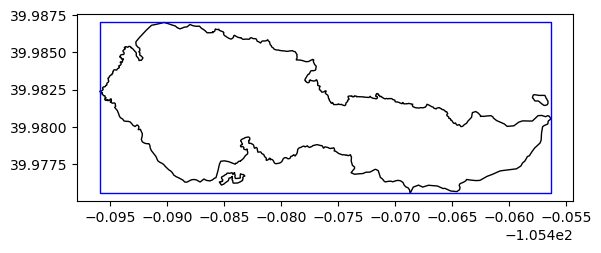

In [14]:
# Plot perimeter and envelope to check download
ax = cs_perimeter_4326_gdf.plot(facecolor='none', edgecolor='black')
cs_envelope_4326_gdf.plot(ax=ax, facecolor='none', edgecolor='blue')

## Multispectral Data

Use multispectral data from the [National Agricuture Imagery Program](https://naip-usdaonline.hub.arcgis.com/) for this analysis. Multispectral imagery can be enhanced using [false color images](https://earthobservatory.nasa.gov/features/FalseColor/page6.php) or [spectral indices]() in order to highlight phenomena such as vegetation health, wetness, or heat. In this analysis, you will produce a color infrared (CIR) false color image as well as a normalized difference vegetation index (NDVI) image. Both of these methods will enhance differences in vegetation health captured by the data.

In the cell below, describe these data, including a citation. 

The data that you will use for this week are available from **Earth Explorer**. Download the data manually using [textbook instructions](https://www.earthdatascience.org/courses/use-data-open-source-python/multispectral-remote-sensing/intro-naip/get-naip-data-earth-explorer/)

  
In the cell below, explain how the user can access the data. Provide an overview of the data source, a citation, and **COMPLETE** download instructions. Instructions should include any required information not already available in the code, including:
 - working urls
 - all necessary parameters
 - the path at which to save the data.

## Load in your data
Use the cell below to:
 - Load data in using `rxr.open_rasterio`
 - Clip the data to the fire boundary **envelope**
 - Add the date to each Dataset
 - Label the bands of your Dataset
 - Concatenate your Datasets
 
Hints:
   - You can use the glob package to get the full paths to any .tif files in your working directory.
   - `DataArray.assign_coords()` can be used to add a date dimension
   - If you clip to the fire boundary itself, you will not be able to compare measurements inside and outside the boundary!

In [15]:
%%bash
find ~/earth-analytics/data/cold-springs

/c/Users/nasim/earth-analytics/data/cold-springs
/c/Users/nasim/earth-analytics/data/cold-springs/cold-springs-envelope
/c/Users/nasim/earth-analytics/data/cold-springs/cold-springs-envelope/cold-springs-envelope-zip.zip
/c/Users/nasim/earth-analytics/data/cold-springs/cold-springs-envelope/cold-springs-envelope.cpg
/c/Users/nasim/earth-analytics/data/cold-springs/cold-springs-envelope/cold-springs-envelope.dbf
/c/Users/nasim/earth-analytics/data/cold-springs/cold-springs-envelope/cold-springs-envelope.prj
/c/Users/nasim/earth-analytics/data/cold-springs/cold-springs-envelope/cold-springs-envelope.shp
/c/Users/nasim/earth-analytics/data/cold-springs/cold-springs-envelope/cold-springs-envelope.shx
/c/Users/nasim/earth-analytics/data/cold-springs/cold_springs_fire_perimeter.geojson
/c/Users/nasim/earth-analytics/data/cold-springs/fire_crop_box_500m_envelope
/c/Users/nasim/earth-analytics/data/cold-springs/fire_crop_box_500m_envelope/fire_crop_box_500m_envelope.cpg
/c/Users/nasim/earth-an

In [24]:
# Load .tif files into xarray
tif_pattern = os.path.join('naip-manual', '*', '*.tif')
naip_files = glob.glob(tif_pattern)
date_re = re.compile(r'm_3910505_nw_13_1_(?P<date>\d+)\.tif')

naip_das = []
naip_crs = None
for naip_file in naip_files:
    # Extract date
    date = pd.to_datetime(date_re.search(naip_file).group('date'))
    # date = pd.to_datetime(naip_file[-12:-4])

    # Opening files
    single_ts_da = rxr.open_rasterio(naip_file, masked=True).squeeze()
    if naip_crs is None:
        naip_crs = single_ts_da.rio.crs
        cs_envelope_naip_gdf = cs_envelope_4326_gdf.to_crs(naip_crs)
    
    single_ts_da = single_ts_da.rio.clip(cs_envelope_naip_gdf)
    single_ts_da = single_ts_da.assign_coords(date=date)
    naip_das.append(single_ts_da)

naip_da = xr.concat(naip_das, dim='date')
naip_da

<xarray.DataArray (date: 2, band: 4, y: 1287, x: 3383)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * band         (band) int32 1 2 3 4
  * x            (x) float64 4.577e+05 4.577e+05 4.577e+05 ... 4.61e+05 4.61e+05
  * y            (y) float64 4.426e+06 4.426e+06 ... 4.425e+06 4.425e+06
    spatial_ref  int32 0
  * date         (date) datetime64[ns] 2015-09-19 2017-09-02
Attributes:
    AREA_OR_POINT:             Area
    TIFFTAG_IMAGEDESCRIPTION:  OrthoVista
    TIFFTAG_RESOLUTIONUNIT:    1 (unitless)
    TIFFTAG_SOFTWARE:          Trimble Germany GmbH
    TIFFTAG_XRESOLUTION:       1
    TIFFTAG_YRESOLUTION:       1
    scale_factor:              1.0
    add_offset:                0.0

(array([1.497137e+06, 5.553478e+06, 9.855394e+06, 6.078747e+06,
        4.258356e+06, 3.508972e+06, 2.348595e+06, 1.030682e+06,
        1.415460e+05, 2.197000e+03]),
 array([  2. ,  25.9,  49.8,  73.7,  97.6, 121.5, 145.4, 169.3, 193.2,
        217.1, 241. ], dtype=float32),
 <BarContainer object of 10 artists>)

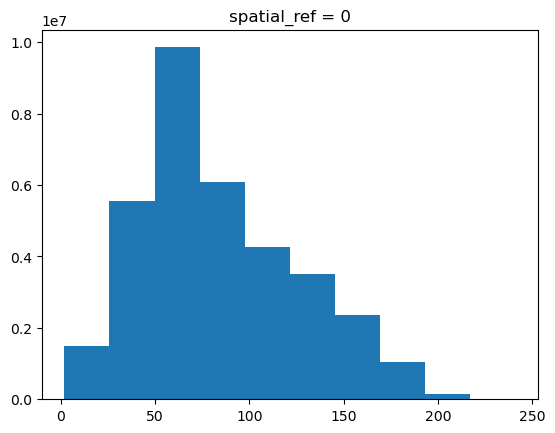

In [28]:
naip_da.plot()

# RGB & CIR Images

In the cell below, produce a figure that:
  - Has four panels: RGB and CIR images from pre- and post-fire Cold Springs, CO, plotted using xr.plot.imshow or et.plot_bands.
  - Displays the fire boundary on **each** image
  - Has five labels: Each panel and the entire figure
  - Contains an additional text overlay with the data source (NAIP)

### Hints 

* Make sure that you use the correct bands to create both images.
    * In a CIR image, the:
      * Infrared band will appear red.
      * Red band will appear green.
      * Green band will appear blue.
* `ax.text()` can be used to create data labels
* Use for loops and/or functions to keep your code DRY
* The default spatial interpolation method results in floating point numbers 0-255, which is not compatible with `imshow()`. You may either:
   * Divide by 255 to get floating point numbers between 0 and 1
   * Go back and reproject using the `'nearest'` method so that the data remain integers.

<AxesSubplot:title={'center':'spatial_ref = 0, date = 2017-09-02'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

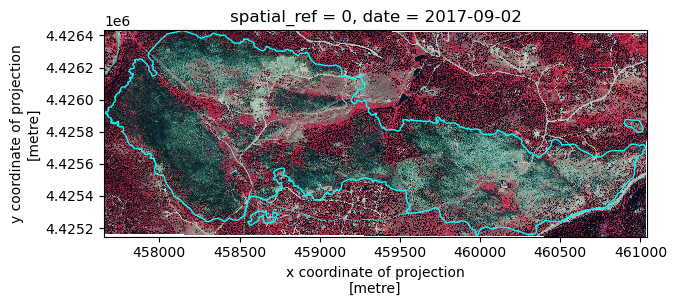

In [21]:
# define and assign a value to the naip_plt_2017_da variable
naip_plt_2017_da = naip_da.sel(date='2017', band=[4, 1, 2]).squeeze() / 255

# re-run the code that uses naip_plt_2017_da
cs_perimeter_naip_gdf = cs_perimeter_4326_gdf.to_crs(naip_plt_2017_da.rio.crs)
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
naip_plt_2017_da.plot.imshow(ax=ax)
cs_perimeter_naip_gdf.plot(ax=ax, facecolor='none', edgecolor='cyan')

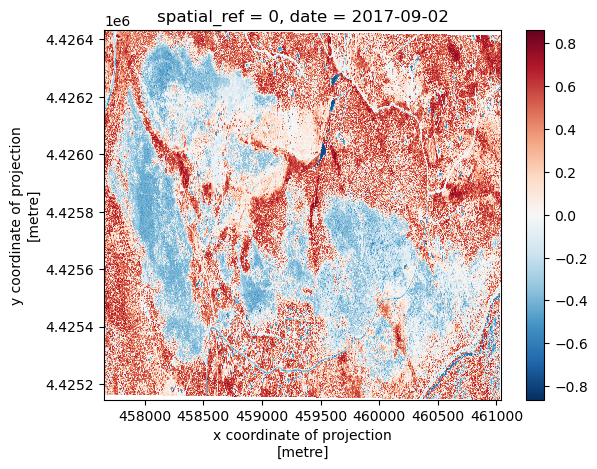

In [20]:
def norm_diff(band_1, band_2):
    return (band_1 - band_2) / (band_1 + band_2)

ndvi = norm_diff(naip_plt_2017_da.sel(band=4), naip_plt_2017_da.sel(band=1))
ndvi.plot.imshow()

## Question 1 (5 points)

1. What does the CIR image highlight?
2. Which band, and which the wavelengths contained in that band, allow a CIR image to highlight the thing that you identified above?

Answer the questions in the Markdown cell below.


## Calculate and plot the DIFFERENCE between NDVI in 2017 and 2015. 

To calculate difference, **subtract the pre-fire data from the post fire data (post - pre)** to ensure that negative values represent a **decrease** in NDVI between the two years. 

### Hints:
  - You can take the difference between subsequent dates using the `DataArray.diff('date')` method.
  - Since you will be computing NDVI more than once, write a function to do that to keep your code DRY. **ALL functions should have numpy-style docstrings**

In [39]:
# define and assign a value to the naip_plt_2015_da variable
naip_plt_2015_da = naip_da.sel(date='2015', band=[4, 1, 2]).squeeze() / 255

# calculate the difference between NDVI in 2017 and 2015
ndvi_diff = naip_plt_2017_da - naip_plt_2015_da
ndvi_diff

<xarray.DataArray (band: 3, y: 1287, x: 3383)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int32 4 1 2
  * x            (x) float64 4.577e+05 4.577e+05 4.577e+05 ... 4.61e+05 4.61e+05
  * y            (y) float64 4.426e+06 4.426e+06 ... 4.425e+06 4.425e+06
    spatial_ref  int32 0

# Create a Plot of the Difference NDVI from 2017 & 2015 (10 points)

This plot should:
  - Use the NAIP data downloaded from Earth Explorer.
    - Ensure that the data from both years are clipped to the same extent, 
    - and are reprojected in the same CRS (this should already be done.)
  - Include the Cold Springs fire polygon boundary on your plot.
  - Include a descriptive title
  - Include a labeled color bar
  - Include an annotation stating the data source

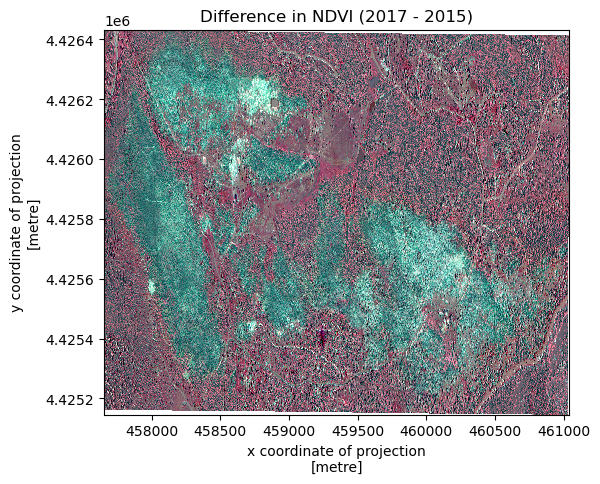

In [40]:
# plot the difference using imshow
fig, ax = plt.subplots(figsize=(6, 5))
ndvi_diff.plot.imshow(ax=ax, cmap='RdYlGn', vmin=-0.5, vmax=0.5, 
                      add_colorbar=False)
ax.set_title('Difference in NDVI (2017 - 2015)')
plt.show()

## Question 2 (5 points)

1. What do the negative dNDVI values in the plot above indicate?

Write 1-3 sentences in the Markdown cell below.

Negative values of the difference in NDVI (dNDVI) indicate a decrease in vegetation between the time period of 2015 and 2017. This damages mainly caused by Cold Spring Fires. 